## Intro

Como modelo base elegimos Gradient Boosting, el cual está basado en árboles de decisión y nos brinda la versatilidad de controlar el overfitting mediante diferentes parámetros, como learning_rate, n_estimators y max_depth.

Además, nos da la posibilidad de controlar el punto óptimo de iteración con el número de estimators, evitando que el modelo siga entrenando innecesariamente y termine empeorando su rendimiento.

## Librerias

In [1]:
# Tratado de datos

import pandas as pd
import numpy as np
import sys

# Flujo 

from imblearn.pipeline import Pipeline

# Preprocesamiento

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Separacion de datos 

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV

# Balanceo de datos

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


# Escalado 

from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Modelo 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
import hdbscan

# Evaluacion 

from sklearn.metrics import roc_auc_score, f1_score,accuracy_score,recall_score,classification_report,confusion_matrix,precision_score

# visualizacion

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## Pipelines y Funciones

In [3]:
# Importamso el Pipeline

sys.path.append('../../src/utils')

from Pipeline import pipeline,pipeline_clustering,pipeline_pca


## Datos

In [4]:
# importamos y agregamos nuestro archivo a una variable 

df= pd.read_parquet('../../data/processed/telecom_limpio.parquet')

In [4]:
# Mostramos df  

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,num_servicios,senior_sin_partner
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,2,0
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,0,3,0
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,4,0
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2,0
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,0


## Gradient Boosting (Parametros)

In [5]:
# Separamos nuestras column objetivo de las columnas que usaremos para predecir 

X= df.drop('Churn',axis=1)
y = df['Churn']

In [6]:
# dividimos nuestro dataset en  entrenamiento y prueba  y asignamos una tamanho de prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Organizaremos las columnas que pasaremos a numericas con las distintas tecnicas de convercion 

cate_ordinal= ['MultipleLines','InternetService','OnlineSecurity',
               'OnlineBackup','DeviceProtection','TechSupport',
               'StreamingTV','StreamingMovies','Contract','PaymentMethod']

cate_onehot= ['gender','Partner','Dependents',
              'PhoneService','PaperlessBilling']

In [8]:
pipeline.set_params(preproceso__transformers = [('ordi',OrdinalEncoder(),cate_ordinal),
                                                ('onehot',OneHotEncoder(),cate_onehot)],
                    balanceo= SMOTETomek(random_state=42),
                    escalado=StandardScaler(),
                    modelo = GradientBoostingClassifier(n_iter_no_change=20,
                                                        verbose=1,
                                                        random_state=42))
parametros={'modelo__n_estimators':[64,100,200],
            'modelo__max_depth':[2,3],
            'modelo__learning_rate':[0.03],
            'modelo__min_samples_leaf':[5,10,15]}

grid=GridSearchCV(estimator=pipeline,
                        param_grid=parametros,
                        scoring='f1',
                        verbose=1,
                        refit=True,
                        n_jobs=-1,
                        cv=5,)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
      Iter       Train Loss   Remaining Time 
         1           1.3619            1.94s
         2           1.3389            1.88s
         3           1.3172            1.76s
         4           1.2967            1.93s
         5           1.2773            1.75s
         6           1.2589            1.83s
         7           1.2414            1.79s
         8           1.2247            1.77s
         9           1.2089            1.72s
        10           1.1937            1.69s
        20           1.0732            1.55s
        30           0.9910            1.57s
        40           0.9261            1.33s
        50           0.8686            1.07s
        60           0.8225            0.84s
        70           0.7871            0.63s
        80           0.7586            0.42s
        90           0.7297            0.21s
       100           0.7073            0.00s


c:\Users\gabri\Documents\Telco_Customer_Churn\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproceso',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordi',
                                                                         OrdinalEncoder(),
                                                                         ['MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaymentMethod']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dep...
                                                                          'PaperlessBilling'])])),
                                       ('balanceo',
                                        SMOTETomek(random_state=42)),
                                       ('escalado', StandardScaler()),
                                       ('modelo',
                                        GradientBoostingClassifier(n_iter_no_change=20,
                                                                   random_state=42,
                                                                   verbose=1))]),
             n_jobs=-1,
             param_grid={'modelo__learning_rate': [0.03],
                         'modelo__max_depth': [2, 3],
                         'modelo__min_samples_leaf': [5, 10, 15],
                         'modelo__n_estimators': [64, 100, 200]},
             scoring='f1', verbose=1)

In [9]:
print(grid.best_params_)
print(grid.best_score_)

{'modelo__learning_rate': 0.03, 'modelo__max_depth': 3, 'modelo__min_samples_leaf': 5, 'modelo__n_estimators': 100}
0.6251239738968389


In [10]:
y_test_pred =grid.predict(X_test)
y_train_pred =grid.predict(X_train)

In [11]:
print(f'precision en prueba : {precision_score(y_test, y_test_pred,average="weighted")}')
print(f'precision en entrenamiento : {precision_score(y_train, y_train_pred,average="weighted")}')

precision en prueba : 0.8157694482539055
precision en entrenamiento : 0.8035915490016975


In [12]:
y_test_pred_Auc =grid.predict_proba(X_test)[:, 1]

print(f'Auc-roc en prueba : {roc_auc_score(y_test, y_test_pred)}')


Auc-roc en prueba : 0.7789704679785108


In [13]:

print(f'Recall:{recall_score(y_test, y_test_pred)}')

Recall:0.7587131367292225


Con los ajustes de estos hiperparámetros, ahora sí podemos decir que nuestro modelo mejoró bastante y no está sobreentrenado, alcanzando una precisión del 81.57%. Además, logra una clasificación correcta por categoría del 78%, según la métrica de evaluación AUC-ROC, y acierta en el 76% de los casos al predecir positivos reales.

Aun con estos buenos resultados, debemos tener en cuenta que, durante nuestro EDA, observamos algunas columnas con mucha correlación en nuestro heatmap, lo cual podríamos considerar para optimizar aún más nuestro modelo.

para no quedarnos solo con el analisis exploratorio aplicaremos un feauture importance para ver la importancia de nuestras columnas y no solo quedarnos con la conclusion del EDA

## Gradient Boosting (Parametros + Feature Importance)

In [14]:
# Vemos los nombres de nuestras columnas ya modificados 

col = grid.best_estimator_.named_steps['preproceso'].get_feature_names_out()

# Vamos a armar un df con nuestras colujmnas transformadas y su importancia

importancia = grid.best_estimator_.named_steps['modelo'].feature_importances_

importancia_df = pd.DataFrame({'feature' : col,
                               'importancia':importancia,}).sort_values(by='importancia',
                                                                        ascending=True)

Text(0.5, 1.0, 'Feature Importance')

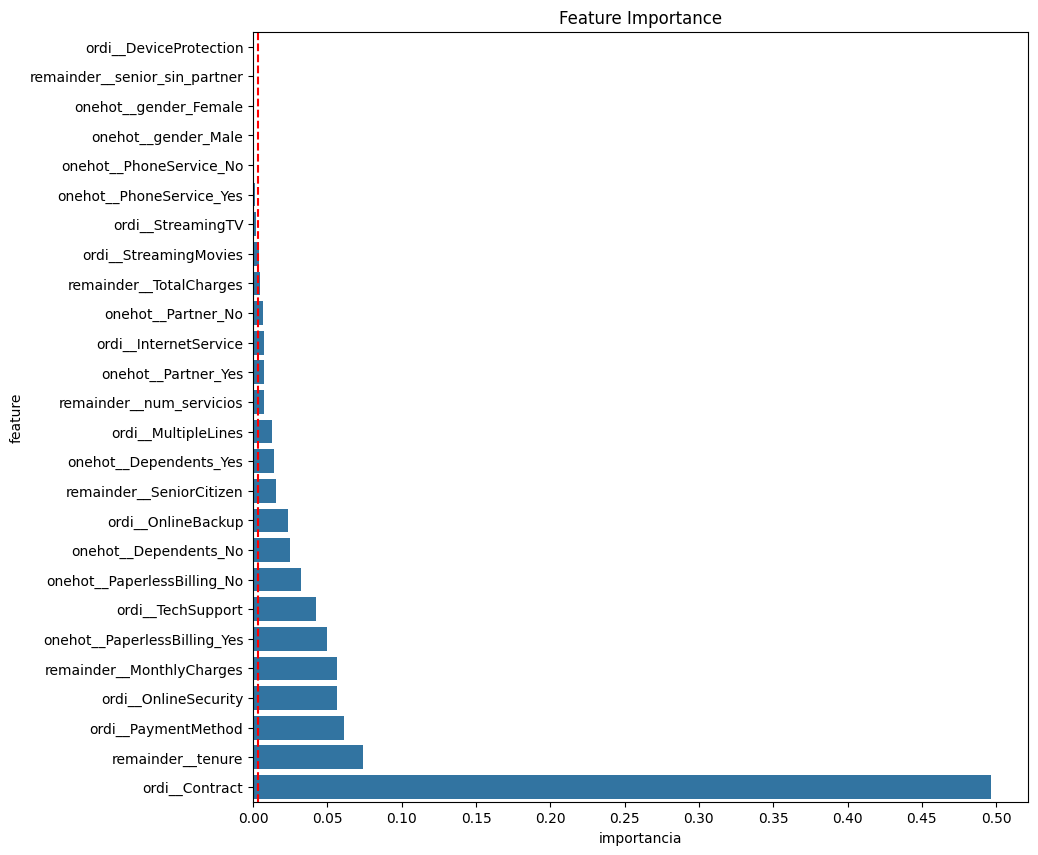

In [15]:
# Graficamos nuestro nuevo df


plt.figure(figsize=(10,10))

sns.barplot(data=importancia_df,
            x='importancia', 
            y='feature')
plt.locator_params(axis='x', nbins=20)
plt.axvline(x=0.003
, color='red', linestyle='--')
plt.title('Feature Importance')

Al visualizar la importancia de cada columna en nuestro modelo, detectamos varias que no aportan información relevante. Podemos eliminarlas sin afectar la precisión, lo que nos permite reducir la dimensionalidad y disminuir el coste computacional.

In [16]:
X= df.drop(['DeviceProtection','senior_sin_partner','gender','PhoneService','StreamingTV','Churn'],axis=1)

y = df['Churn']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Organizaremos las columnas que pasaremos a numericas con las distintas tecnicas de convercion 

cate_ordinal= ['MultipleLines','InternetService','OnlineSecurity',
               'OnlineBackup','TechSupport','Contract',
               'PaymentMethod','StreamingMovies',]

cate_onehot= ['Partner','Dependents',
              'PaperlessBilling']

In [19]:
pipeline.set_params(preproceso__transformers = [('ordi',OrdinalEncoder(),cate_ordinal),
                                                ('onehot',OneHotEncoder(),cate_onehot)],
                    balanceo= SMOTETomek(random_state=42),
                    escalado=StandardScaler(),
                    modelo = GradientBoostingClassifier(n_iter_no_change=20,
                                                        verbose=1,
                                                        random_state=42))
parametros={'modelo__n_estimators':[64,100,200],
            'modelo__max_depth':[2,3],
            'modelo__learning_rate':[0.03],
            'modelo__min_samples_leaf':[5,10,15]}

grid=GridSearchCV(estimator=pipeline,
                        param_grid=parametros,
                        scoring='f1',
                        verbose=1,
                        refit=True,
                        n_jobs=-1,
                        cv=5,)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
      Iter       Train Loss   Remaining Time 
         1           1.3623            1.57s
         2           1.3397            1.54s
         3           1.3183            1.50s
         4           1.2981            1.46s
         5           1.2789            1.48s
         6           1.2606            1.47s
         7           1.2433            1.45s
         8           1.2268            1.44s
         9           1.2111            1.44s
        10           1.1961            1.42s
        20           1.0772            1.27s
        30           0.9954            1.12s
        40           0.9312            0.96s
        50           0.8666            0.80s
        60           0.8232            0.64s
        70           0.7879            0.48s
        80           0.7591            0.32s
        90           0.7338            0.16s
       100           0.7113            0.00s


c:\Users\gabri\Documents\Telco_Customer_Churn\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproceso',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordi',
                                                                         OrdinalEncoder(),
                                                                         ['MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'TechSupport',
                                                                          'Contract',
                                                                          'PaymentMethod',
                                                                          'StreamingMovies']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Partner',
                                                                          'Dependents',
                                                                          'PaperlessBilling'])])),
                                       ('balanceo',
                                        SMOTETomek(random_state=42)),
                                       ('escalado', StandardScaler()),
                                       ('modelo',
                                        GradientBoostingClassifier(n_iter_no_change=20,
                                                                   random_state=42,
                                                                   verbose=1))]),
             n_jobs=-1,
             param_grid={'modelo__learning_rate': [0.03],
                         'modelo__max_depth': [2, 3],
                         'modelo__min_samples_leaf': [5, 10, 15],
                         'modelo__n_estimators': [64, 100, 200]},
             scoring='f1', verbose=1)

In [20]:
y_test_pred =grid.predict(X_test)
y_train_pred =grid.predict(X_train)

In [21]:
print(f'precision en prueba : {precision_score(y_test, y_test_pred,average="weighted")}')
print(f'precision en entrenamiento : {precision_score(y_train, y_train_pred,average="weighted")}')

precision en prueba : 0.8160907136779986
precision en entrenamiento : 0.8026132131638251


In [22]:
y_test_pred_Auc =grid.predict_proba(X_test)[:, 1]

print(f'Auc-roc en prueba : {roc_auc_score(y_test, y_test_pred)}')

Auc-roc en prueba : 0.7788100241183351


In [23]:
print(f'Recall:{recall_score(y_test, y_test_pred)}')

Recall:0.7506702412868632


Quitando algunas columnas que no proporcionaban mucho a nuestro modelo, nuestro modelo mejoró un poco en todas las metricas de evaluacion

# Análisis de variables predictoras y distribución de objetivo

Satisfechos con los resultados obtenidos hasta el momento, procederemos a analizar la influencia de las variables en el modelo utilizando el método SHAP

In [24]:
# extraemos los datos sin el balanceo ya que shap evalua los datos originales sin alterar la distribucion 

preproceso = grid.best_estimator_.named_steps["preproceso"]
modelo = grid.best_estimator_.named_steps["modelo"]


X_test_transformado = preproceso.transform(X_test)


columnas_transformadas = preproceso.get_feature_names_out(X_test.columns)

X_test_df = pd.DataFrame(X_test_transformado, columns=columnas_transformadas)

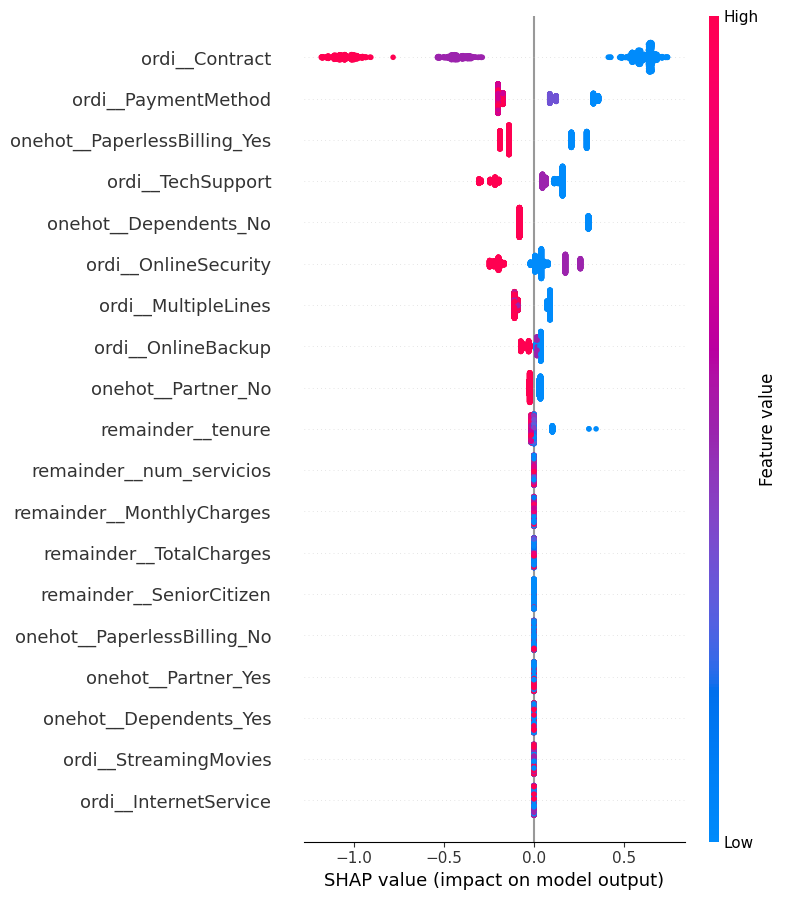

In [25]:
explainer = shap.Explainer(modelo, X_test_df)

valores = explainer(X_test_df)


shap.summary_plot(valores, features=X_test_df, feature_names=X_test_df.columns)

En este gráfico de resumen podemos observar cómo y en qué magnitud influye cada una de las variables en la predicción del modelo. Notamos que la duración del contrato tiene un impacto considerable, lo cual refuerza la hipótesis que formulamos durante el análisis exploratorio. Otras variables relevantes a tener en cuenta son el método de pago y la facturación electrónica. El resto de las variables tiene un impacto menor, pero no por eso dejan de ser importantes

Text(0.5, 1.0, 'Predicciones de abandono')

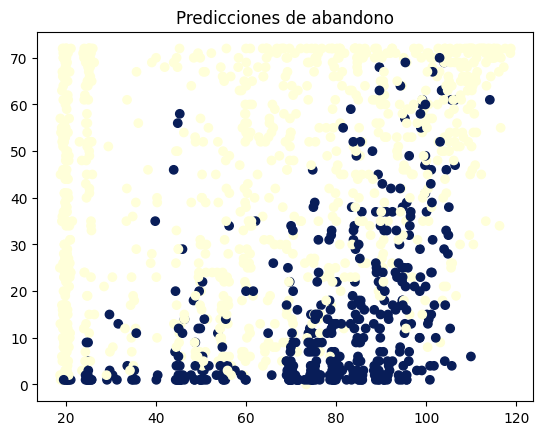

In [26]:
plt.scatter(X_test['MonthlyCharges'],
            X_test['tenure'], 
            c=y_test_pred, cmap='YlGnBu')

plt.title('Predicciones de abandono')

En este gráfico de dispersión podemos observar cómo el modelo está separando las clases, demostrando además una buena capacidad de generalización. Comparado con el primer modelo, este logra una separación significativamente mejor. Sin embargo, aún existe margen de mejora, por lo que continuaremos trabajando para refinar tanto la precisión como la robustez del modelo.

# Conclusion General

A lo largo de este proyecto se abordó el problema de fuga de clientes mediante un enfoque integral que combinó análisis exploratorio de datos (EDA) y modelos de clasificación supervisada.

Durante el EDA identificamos patrones clave: los clientes que abandonan suelen tener contratos de tipo mensual, ser personas mayores o jubiladas, y reportar problemas con servicios como la fibra óptica o el servicio técnico. También detectamos un target desbalanceado, con un 26.5% de clientes en la clase de abandono, lo que nos llevó a aplicar técnicas de balanceo para mejorar la calidad del modelo.

Con base en estos hallazgos, desarrollamos un modelo de clasificación capaz de adaptarse a relaciones no lineales en los datos. Utilizamos métricas como AUC-ROC, F1-score, Precision y Recall para evaluar su rendimiento. El análisis con SHAP confirmó que la duración del contrato, el método de pago y la facturación electrónica son factores de gran impacto en la predicción, validando nuestras hipótesis iniciales.

El modelo muestra una buena capacidad de generalización y mejora sustancial en la separación de clases respecto al modelo inicial. No obstante, aún hay margen de mejora, por lo que se recomienda seguir ajustando hiperparámetros, explorar otros algoritmos y considerar más fuentes de datos.

Desde una perspectiva de negocio, los resultados sugieren que estrategias como ofrecer contratos de mayor duración, mejorar el servicio técnico y asegurar una experiencia estable con la fibra óptica pueden ser clave para reducir la tasa de abandono de clientes.

